```
SPDX-License-Identifier: Apache-2.0

Copyright (C) 2021, Arm Limited and contributors

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

# Exploring confidence intervals from model's output

In this notebook, we will show an example on how to visualise confidence intervals in CIFAR10 outputs, for a stochastic model.

In [1]:
%matplotlib inline

import sys
sys.path.append('..')

from PIL import Image

#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

from datasets import cifar10
from models.resnet20 import model, trainer, parser, inferencer, benchmarker, converter
from common import mcdo, brancher, utils

import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc

CIFAR10_LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Running infence on model and understanding outputs

In [2]:
## Adapted from `inference()` in `ResNet20.py`

# Loading pre-trained model
my_model = model.Model()
my_model.load('../experiment_models/tf/full_mcdo.h5')

# Preparing CIFAR10 dataset with batch size of 1 
# (batch size of 1 will make it easier to access individual images later in this notebook, but for better speed you should increase this value)
inputs = cifar10.CIFAR10()
inputs.configure(1)
inputs.prepare()

# Run inference on model to get logits
inference = inferencer.Inferencer()
inference.configure(inputs.get_test_split(), 1, my_model.model_format)
predictions, true_labels = inference.run(my_model.model)

10000/10000 [==============================] - 174s 17ms/step


In [3]:
# Model has 5 branches, corresponding to different samples from the model: (num_branches, num_elements_in_dataset, num_classes)
print(f'Shape of `predictions`: {predictions.shape}')
print(f'Shape of `true_labels`: {true_labels.shape}')

Shape of `predictions`: (5, 10000, 10)
Shape of `true_labels`: (10000,)


In [4]:
# Applying softmax() on logits output
softmax_predictions = sc.softmax(predictions, axis=-1)
softmax_predictions.shape
print(f'Shape of `softmax_predictions`: {softmax_predictions.shape}')

Shape of `softmax_predictions`: (5, 10000, 10)


In [5]:
# We provide an off-the-shelf utility function to give useful outputs from the samples
# Here, confidence intervals will be calculated for a 95% confidence interval
mean_preds, lower_lim, upper_lim, std_preds = utils.calculate_output(predictions, confidence_interval=0.95)

In [6]:
# Uncomment and execute this cell to retrieve its documentation
#utils.calculate_output?

In [7]:
# Checking shapes
print(f'Shape of `mean_preds`: {mean_preds.shape}')
print(f'Shape of `lower_lim`: {lower_lim.shape}')
print(f'Shape of `upper_lim`: {upper_lim.shape}')
print(f'Shape of `std_preds`: {std_preds.shape}')

Shape of `mean_preds`: (10000, 10)
Shape of `lower_lim`: (10000, 10)
Shape of `upper_lim`: (10000, 10)
Shape of `std_preds`: (10000, 10)


## Choosing input examples to analyse

We will be exploring the following 4 images from CIFAR10.

## Input example 0


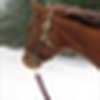

## Input example 49


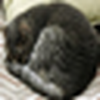

## Input example 605


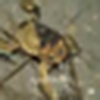

## Input example 1009


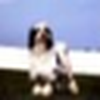

In [8]:
pil_images = {}
pil_labels = {}

for i, elem in enumerate(inputs.ds_test):
    if i in [0, 49, 605, 1009]:
        print(f'## Input example {i}')
        img = Image.fromarray((elem[0][0].numpy()* 255).astype(np.uint8), 'RGB')
        pil_images[i] = img
        pil_labels[i] = CIFAR10_LABELS[true_labels[i]]
        img = img.resize((100,100), Image.ANTIALIAS)
        display(img)

## Visually inspecting confidence intervals

The following plots allow us to visually inspect the sampled softmax scores from the stochastic model, as well as the corresponding confidence intervals, for 4 representative examples in CIFAR10.

It is possible to see that for the CIFAR10 example with ID 1009 (`input_example=1009`), we have a very high level of uncertainty for classes `airplane`, `dog`, and `truck` because their confidence intervals are very wide (e.g. ranging from around `0.1` to `0.9` for `dog`); on the contrary, for the other classes, the confidence intervals are narrow and mostly close to zero. This indicates that the model is in doubt on whether the output for this example 1009 is `airplane`, `dog`, or `truck`, but not any other class. This level of uncertainty is illustrated by the plot in the middle (i.e. `Outputs for input_example=1009`), as we see different samples having an opposite behaviour when identifying which of `dog` or `truck` should be the correct output. This highlights the utility of uncertainty estimations for what could be an otherwise over-confident model.

For `input_example=0` it is very clear that the model thinks the input correspond to class `horse`, as the confidence interval is narrow and convering very high values above `0.9`, while all the other classes are very close to zero.

In [9]:
# Utily function for plotting
def plot_sampled_scores(example_id):
    _, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plotting the corresponding CIFAR10 image
    axs[0].use_sticky_edges = False
    axs[0].imshow(np.asarray(pil_images[example_id]))
    axs[0].margins(0.5)
    axs[0].axis('off')
    axs[0].set_title(f'input_example={example_id} \n(gt_label={pil_labels[example_id]})')
    
    
    # Outputted sampled
    for i in range(5):
        axs[1].scatter(CIFAR10_LABELS, softmax_predictions[i, example_id, :], label=f'Sample {i+1}')
        axs[1].legend()

    axs[1].set_ylim(0, 1)
    axs[1].set_xlabel('Class')
    axs[1].set_ylabel('Softmax Score')
    axs[1].set_title(f'Outputs for input_example={example_id}')    
    for tick in axs[1].get_xticklabels():
        tick.set_rotation(45)
    
    
    # Right plot for confidence intervals
    axs[2].set_title(f'Confidence intervals for input_example={example_id}')
    axs[2].set_ylim(0, 1)

    for lower, upper, x in zip(lower_lim[example_id], upper_lim[example_id], CIFAR10_LABELS):
        axs[2].plot((x, x), (lower, upper), 'b-', zorder=1)
    axs[2].scatter(CIFAR10_LABELS, lower_lim[example_id], marker='_',  c='blue', zorder=2)
    axs[2].scatter(CIFAR10_LABELS, upper_lim[example_id], marker='_', c='blue', zorder=2)
        
    axs[2].scatter(CIFAR10_LABELS, mean_preds[example_id], marker='s', c='red', label='Mean', zorder=3)
    for tick in axs[2].get_xticklabels():
        tick.set_rotation(45)
    axs[2].legend()
    
    
    plt.tight_layout()
    plt.show()
    plt.close()

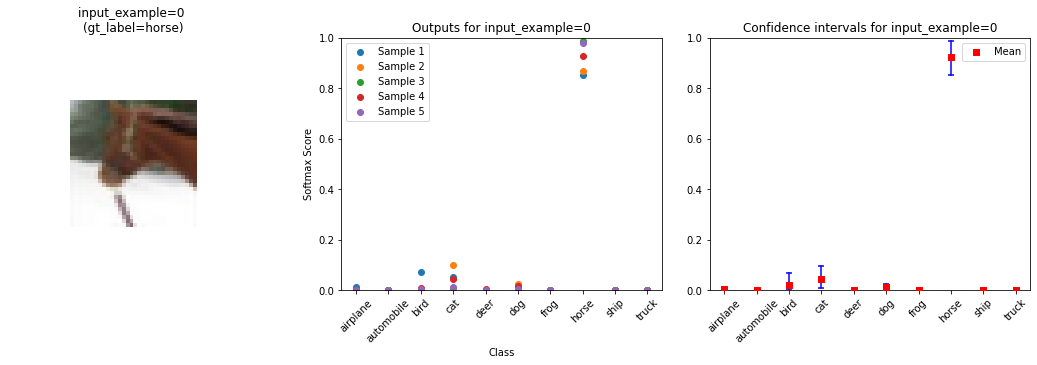

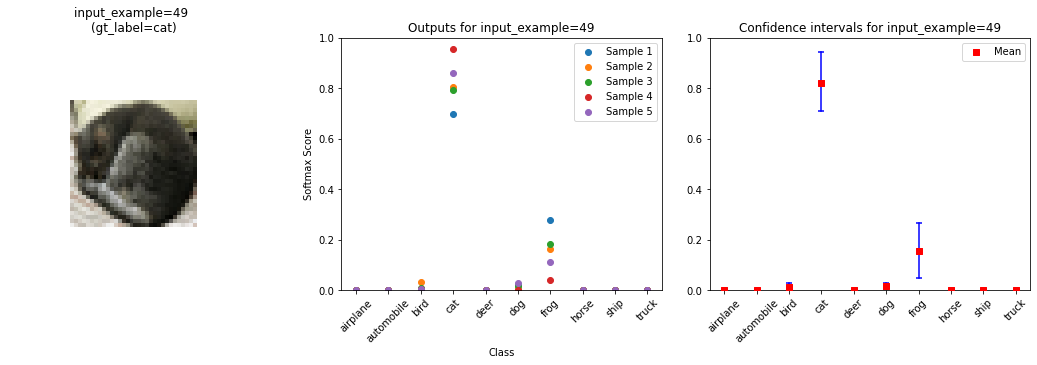

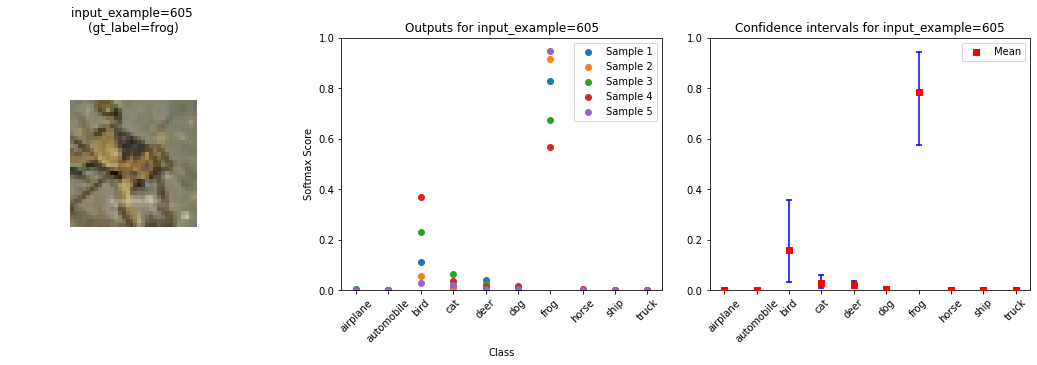

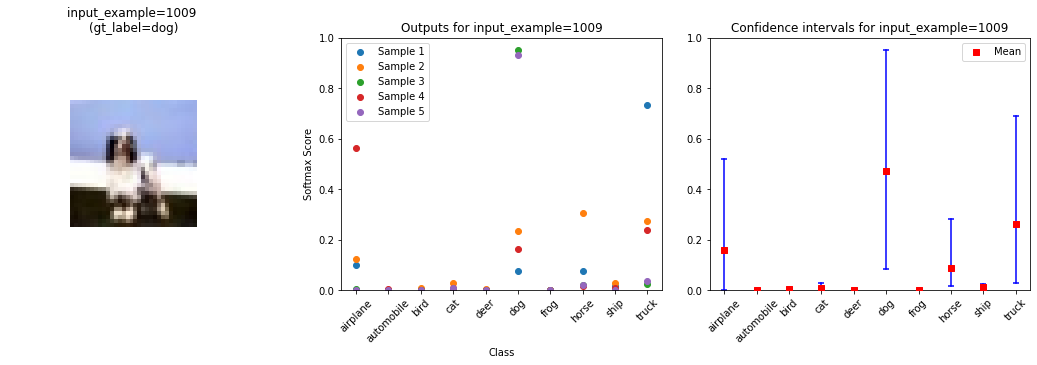

In [10]:
for elem in [0, 49, 605, 1009]:
    plot_sampled_scores(elem)

## Checking images from another dataset

We manually downloaded 4 examples from CIFAR100 to evaluate on the model trained on CIFAR10. We will compare how the outputs compare between the stochastic and corresponding deterministic model (i.e. without dropout activated at inference time).

In [11]:
# Loading deterministic model
deterministic_model = model.Model()
deterministic_model.load('../experiment_models/tf/vanilla.h5')

In [12]:
def calculate_and_plot(output_arr, ax, title, mean_label):
    mean_ood, lower_ood, upper_ood, std_ood = utils.calculate_output(output_arr, confidence_interval=0.95)
    for lower, upper, x in zip(lower_ood[0, :], upper_ood[0, :], CIFAR10_LABELS):
        ax.plot((x, x), (lower, upper), 'b-', zorder=1)
    ax.scatter(CIFAR10_LABELS, lower_ood[0, :], marker='_',  c='blue', zorder=2)
    ax.scatter(CIFAR10_LABELS, upper_ood[0, :], marker='_', c='blue', zorder=2)
        
    ax.scatter(CIFAR10_LABELS, mean_ood[0, :], marker='s', c='red', label=mean_label, zorder=3)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.legend()
    ax.set_title(title)
    #plt.xticks(rotation=45)
    ax.set_ylim(0, 1)
    
    
def run_inference_and_plot(model_stochastic, model_deterministic, image_arr):
    _, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plotting the corresponding CIFAR100 image
    axs[0].use_sticky_edges = False
    axs[0].imshow(image_arr[0])
    axs[0].margins(0.5)
    axs[0].axis('off')
    #axs[0].set_title(f'input_example={example_id}')
    
    stochastic_output = np.array(model_stochastic.predict(image_arr))
    deterministic_output = np.array(model_deterministic.predict(image_arr))[None]
    
    calculate_and_plot(stochastic_output, axs[1], 'Confidence intervals for stochastic model', 'Mean')
    calculate_and_plot(deterministic_output, axs[2], 'Output from deterministic model', 'Output')
    
    
    plt.tight_layout()
    plt.show()
    plt.close()

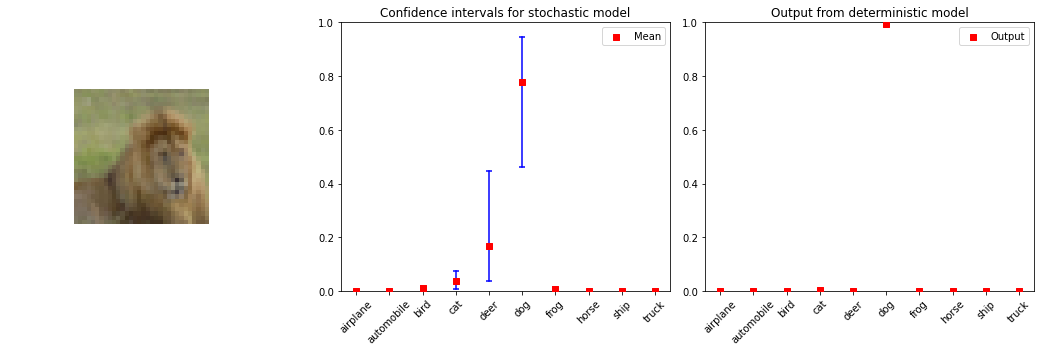

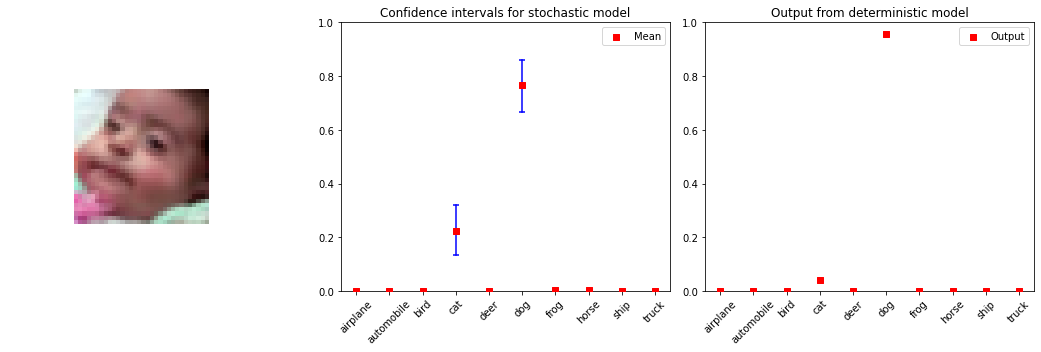

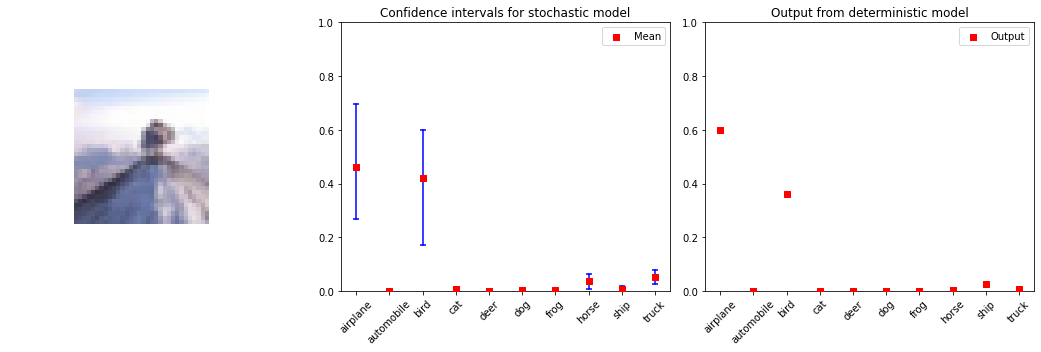

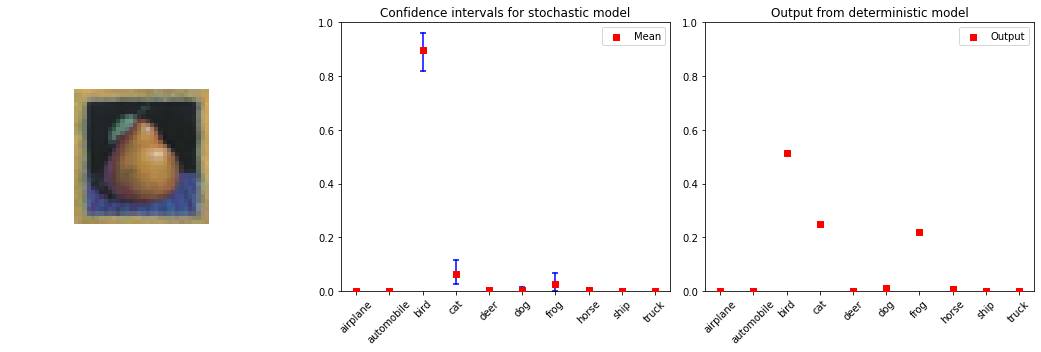

In [13]:
run_inference_and_plot(my_model.model, deterministic_model.model, np.asarray(Image.open('cifar100_lion.png'))[None] / 255.)
run_inference_and_plot(my_model.model, deterministic_model.model,  np.asarray(Image.open('cifar100_baby.png'))[None] / 255.)
run_inference_and_plot(my_model.model, deterministic_model.model,  np.asarray(Image.open('cifar100_mountain.png'))[None] / 255.)
run_inference_and_plot(my_model.model, deterministic_model.model,  np.asarray(Image.open('cifar100_pear.png'))[None] / 255.)